In [53]:
import time
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from stheno.torch import B, GP, EQ, Normal, Measure, Matern12, Matern32, Matern52

from models import MLP
from utils import RunningAverage

from elbo import ApproximatePosterior
from gp_mlp import forward_backward_pass, UpperIndusDataset

# Detect device.
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

import warnings
warnings.filterwarnings('ignore')


In [29]:
# Let all of Stheno run on that device.
B.device(device).__enter__()
    
# B.epsilon is the default value for the diagonal jitter of the matrix
B.epsilon = 1e-4  # Needs to be relatively high for `float32`s

In [30]:
# DEFINE INPUT AND OUTPUT VARIABLES (PREDICTORS AND PREDICTANDS)

predictant = ['Prec']
predictors = [
              'X','Y','Z', 
              'RAIN',
              'doy_sin', 'doy_cos', 
              'W500', 'RH2', 'U500', 'V10', 
              'RH500', 'U10', 'V500', 
              'T2MIN', 'T2', 'T2MAX'
                 ]
    

# DEFINE TRAINING STATIONS
train_stations = ['ABO', 'AHO', 'AIR', 'ALV', 'APT', 'ARO', 'AUB', 'AVA', 'AVB', 'BAC', 'BAL', 'BEA', 'BEC', 'BEGTH', 'BEGWA', 'BEH', 'BEHAK', 'BEKSE', 'BERIF', 'BES', 'BEV', 'BIN', 'BIV', 'BLA', 'BRA', 'BRW', 'BSP', 'BSW', 'CAV', 'CDF', 'CHA', 'CHB', 'CHD', 'CHM', 'CHW', 'CIM', 'COV', 'CTA', 'CTO', 'CUE', 'DAV', 'DIB', 'DIS', 'DLBAL', 'DLFEB', 'DLZUG', 'DMA', 'DOL', 'EIT', 'ENG', 'ERN', 'EVL', 'EVO', 'FIL', 'FIO', 'FIT', 'FLI', 'FRE', 'GEN', 'GOA', 'GRC', 'GRH', 'GSB', 'GSG', 'GST', 'GTT', 'GWA', 'HER', 'HIR', 'HOE', 'INF', 'IYDEO', 'IYDEU', 'IYMMR', 'IYMUW', 'IYPEN', 'IYPFE', 'IYPFI', 'IYPLI', 'IYPRU', 'IYREI', 'IYRID', 'IYROT', 'IYSMG', 'IYSMT', 'IYSUL', 'IYSUM', 'IYSVP', 'IYSWA', 'IYTER', 'IYTOB', 'IYULT', 'IYVAA', 'IYVAL', 'IYWEL', 'IYWOL', 'KLA', 'KRO', 'KSE', 'LBA', 'LEH', 'LEU', 'LOC', 'LOE', 'MAL', 'MAT', 'MAU', 'MLS', 'MOD', 'MSO', 'MST', 'MTE', 'MUE', 'MUS', 'MVE', 'NABCHA', 'NABDAV', 'NAP', 'NEB', 'OBI', 'OBW', 'PDM', 'PIG', 'PIL', 'PLF', 'PON', 'PSB', 'PUD', 'REC', 'ROB', 'ROE', 'ROG', 'RUM', 'SAB', 'SAE', 'SAF', 'SAM', 'SAN', 'SAP', 'SAS', 'SBA', 'SBE', 'SCU', 'SDO', 'SED', 'SEP', 'SGD', 'SIA', 'SIM', 'SLFAM2', 'SLFEM2', 'SLFFIS', 'SLFGL2', 'SLFMEI', 'SLFOBM', 'SLFSA3', 'SLFSC2', 'SLFSC3', 'SLFTU2', 'SLFUR2', 'SLFURS', 'SNE', 'SOG', 'SRL', 'STP', 'SVG', 'SWA', 'TIBED', 'TIBIA', 'TICOL', 'TIFUS', 'TIOLI', 'TST', 'UNS', 'URB', 'VDLSP', 'VDSEP', 'VEL', 'VIO', 'VRI', 'VSANZ', 'VSARO', 'VSBRI', 'VSCHY', 'VSDUR', 'VSEMO', 'VSFIN', 'VSGDX', 'VSJEI', 'VSMAT', 'VSSAB', 'VSSTA', 'VST', 'VSVER', 'WAW', 'WET', 'ZER', 'ZEV', 'ZNZ']

In [31]:
# Dates (but in this notebook we only use data for year 2000)
start="1900-01-01"
end="2020-12-31"

In [32]:
# Data for year 2000
TRAIN_PATH = 'alps_2000.pkl'

### Dataloaders

In [33]:
ds_dataset = UpperIndusDataset(TRAIN_PATH, start, end, predictant, predictors, stations=train_stations)

train_dataloader = DataLoader(dataset=ds_dataset, batch_size=16, shuffle=True)

# Models

In [62]:
num_GP_dims = 2

In [63]:
# This is the MLP used in the GP-MLP model
model = MLP(in_channels= len(predictors)+1,#-num_GP_dims, 
            hidden_channels=[50,50], 
            likelihood_fn='bgmm', # 'gamma', 'ggmm', bgmm', 'b2gmm', 'b2sgmm'
            dropout_rate=0,
           )

print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')

Number of parameters: 3603


In [64]:
model.to(device)

MLP(
  (relu): ReLU()
  (dropout): Dropout(p=0, inplace=False)
  (hidden): ModuleList(
    (0): Linear(in_features=17, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
  )
  (out): Linear(in_features=50, out_features=3, bias=True)
)

### GP-MLP

In [65]:
print_progress = True
plot_x_ind = True
validate_flag = True
f_marginal_flag = False
mc_samples = 5

In [66]:
st = ds_dataset.st
coords_train_stations = st.groupby('Station').mean()[predictors[:num_GP_dims]].values

x_ind_stations = coords_train_stations

In [67]:
# Inducing points are fixed to the station locations
x_ind = torch.tensor(x_ind_stations, dtype=torch.float32).detach().requires_grad_(False).to(device)

num_ind_points = len(x_ind)
n = len(st)

ls = torch.nn.Parameter(torch.tensor(2, dtype=torch.float32, requires_grad=True).to(device))

with Measure() as prior:
    f = GP(EQ().stretch(ls))
    # f = GP(Matern12())
    
q = ApproximatePosterior(num_ind_points, use_device=device) # q is the approximate posterior

optimizer = torch.optim.Adam(list(model.parameters())+list(q.parameters()), lr=10e-4)
# optimizer = torch.optim.Adam(list(model.parameters())+list(q.parameters())+[ls], lr=10e-4)

In [68]:
e_past = 0

train_loss, train_loglik, train_kl, train_nll = [], [], [], []
val_loss, val_loglik, val_kl, val_nll = [], [], [], []

test_loss, test_loglik, test_kl, test_nll  = [], [], [], []

train_loss_batch, train_loglik_batch, train_kl_batch, train_nll_batch = RunningAverage(), RunningAverage(), RunningAverage(), RunningAverage()
val_loss_batch, val_loglik_batch, val_kl_batch, val_nll_batch = RunningAverage(), RunningAverage(), RunningAverage(),RunningAverage()

In [69]:
num_epochs = 20
    
for e in range(e_past + 1, num_epochs):
    
    # TRAIN EPOCH    
    model.train()

    start = time.time()

    train_loss_batch.reset()
    train_loglik_batch.reset()
    train_kl_batch.reset()
    train_nll_batch.reset()
    val_loss_batch.reset()
    val_loglik_batch.reset()
    val_kl_batch.reset()
    val_nll_batch.reset()

    n = train_dataloader.dataset.n
    
    for i, (inputs, labels) in enumerate(train_dataloader):

        inputs = inputs.to(device) # inputs [batch_size, num_predictors, num_stations]
        labels = labels.to(device) # labels [batch_size, num_stations]

        elbo, recon, kl, num_points, nll = forward_backward_pass(inputs, labels, n, model, optimizer, q, f, x_ind, 
                                                            inducing_points=True, backward=True, f_marginal=f_marginal_flag, n_samples=mc_samples,
                                                            num_GP_dims=num_GP_dims, remove_from_inputs=False)

        # Keep track of loss terms
        train_loss_batch.update(-elbo.item())
        train_loglik_batch.update(-recon.item())
        train_kl_batch.update(kl.item())
        train_nll_batch.update(nll.item()/num_points.item())

    elapsed = time.time() - start

    if print_progress:
        print(f'Train epoch  {e}: -elbo: {train_loss_batch.avg:.3f} | kl: {train_kl_batch.avg:.3f} | -recon: {train_loglik_batch.avg:.3f} | nll: {train_nll_batch.avg:.3f} -- time: {elapsed:.2f}')
        print(f'GP lengthscale: {ls.item()}')

    # Add average batch loss terms to lists
    train_loss.append(train_loss_batch.avg)
    train_loglik.append(train_loglik_batch.avg)
    train_kl.append(train_kl_batch.avg)
    train_nll.append(train_nll_batch.avg)
    
# VALIDATION REMOVED

Train epoch  1: -elbo: 732.228 | kl: 44436242.783 | -recon: 3.227 | nll: 3.160 -- time: 4.80
GP lengthscale: 2.0
Train epoch  2: -elbo: 703.340 | kl: 42727589.913 | -recon: 2.370 | nll: 2.291 -- time: 4.63
GP lengthscale: 2.0
Train epoch  3: -elbo: 676.263 | kl: 41090732.522 | -recon: 2.147 | nll: 2.127 -- time: 4.67
GP lengthscale: 2.0
Train epoch  4: -elbo: 650.484 | kl: 39524613.565 | -recon: 2.061 | nll: 2.049 -- time: 5.69
GP lengthscale: 2.0
Train epoch  5: -elbo: 625.839 | kl: 38025694.957 | -recon: 2.006 | nll: 1.998 -- time: 4.75
GP lengthscale: 2.0
Train epoch  6: -elbo: 602.247 | kl: 36590171.826 | -recon: 1.966 | nll: 1.958 -- time: 4.99
GP lengthscale: 2.0
Train epoch  7: -elbo: 579.655 | kl: 35214546.087 | -recon: 1.941 | nll: 1.934 -- time: 4.83
GP lengthscale: 2.0
Train epoch  8: -elbo: 557.998 | kl: 33895628.261 | -recon: 1.922 | nll: 1.915 -- time: 4.86
GP lengthscale: 2.0
Train epoch  9: -elbo: 537.230 | kl: 32630508.087 | -recon: 1.909 | nll: 1.903 -- time: 5.20
GP 

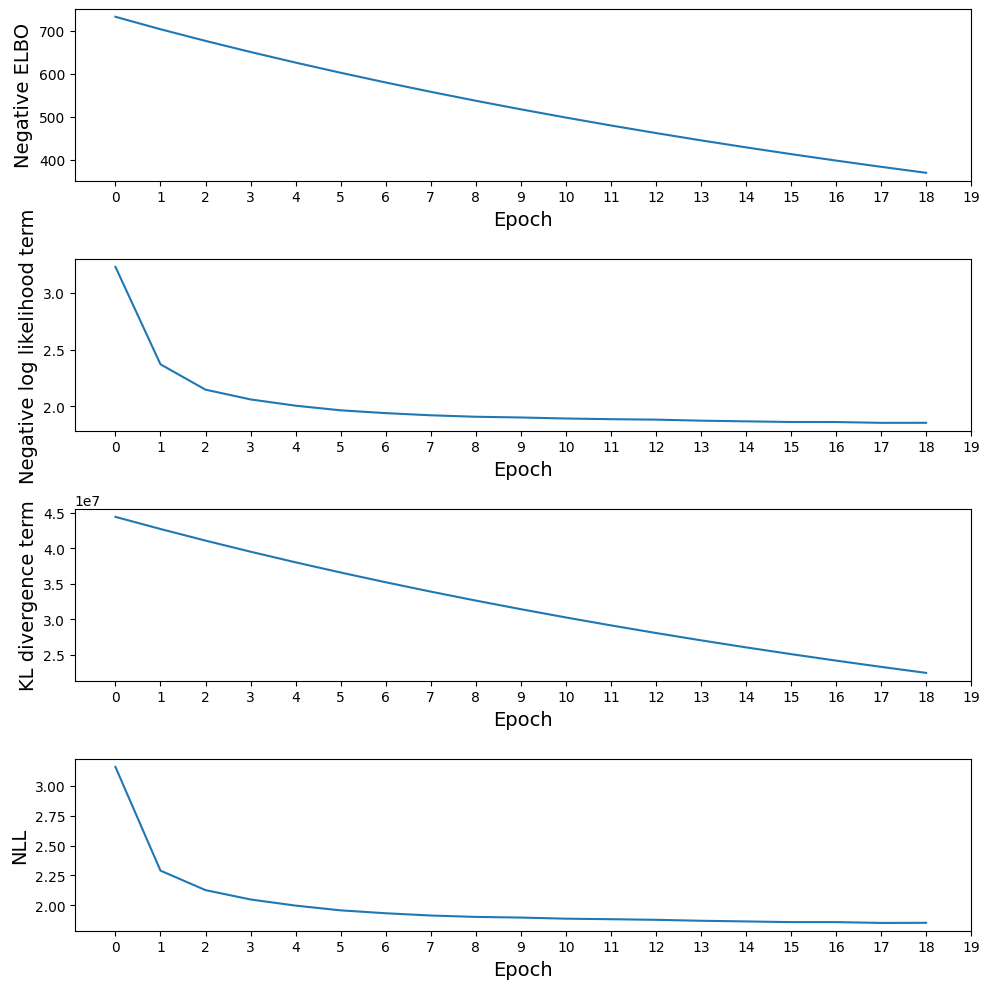

In [70]:
train_vars = [train_loss, train_loglik, train_kl, train_nll] 
validation_vars = [val_loss, val_loglik, val_kl, val_nll]

labels = ['Negative ELBO','Negative log likelihood term','KL divergence term','NLL']

fig, axes = plt.subplots(4,1, figsize=(10,10))
for i,ax in enumerate(axes.flatten()):
    ax.plot(train_vars[i], label='train')
    ax.plot(validation_vars[i], label='val')
#     ax.set_title(f'{labels[i]} | best: {np.min(train_vars[i]):.2f}')
    ax.set_ylabel(f'{labels[i]}', fontsize=14)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_xticks(np.arange(0, num_epochs))
#     ax.set_yscale('log')
plt.tight_layout()
plt.show()